In this tutorial, clustering is performed on the Bragg disks.

In [1]:
import numpy as np
import py4DSTEM
from py4DSTEM.visualize import show
from py4DSTEM.process.utils.cluster import Cluster
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from colorsys import hsv_to_rgb
import matplotlib.pyplot as plt
from emdfile import tqdmnd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
py4DSTEM.__version__

C:\Users\alahe\anaconda3\envs\py4dstem\Lib\site-packages\cupy\_environment.py:541: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
cupyx.jit.rawkernel is experimental. The interface can change in the future.


'0.14.19'

**Load Data**



In [5]:
# Set file paths
filepath_data = "sim_Au_data_all_binned.h5"
filepath_basics_01 = 'data/analysis_basics_01.h5'

In [6]:
# Load the datacube
datacube = py4DSTEM.read(
    filepath = filepath_data,
    datapath = '4DSTEM_simulation/4DSTEM_polyAu'
)

datacube

DataCube( A 4-dimensional array of shape (100, 84, 125, 125) called '4DSTEM_polyAu',
          with dimensions:

              Rx = [0,1,2,...] pixels
              Ry = [0,1,2,...] pixels
              Qx = [0,1,2,...] pixels
              Qy = [0,1,2,...] pixels
)

In [7]:
# Load the prior analysis
basics_01 = py4DSTEM.read(
    filepath_basics_01
)

basics_01.tree()

/
|---annular_dark_field
|---bright_field
|---dp_max
|---dp_mean
|---selected_area_diffraction_01
|---virt_dark_field_01


In [79]:
datacube.crop_R((10,30,10,30)) # reducing the shape of the data

DataCube( A 4-dimensional array of shape (10, 10, 125, 125) called '4DSTEM_polyAu',
          with dimensions:

              Rx = [0,1,2,...] pixels
              Ry = [0,1,2,...] pixels
              Qx = [0,1,2,...] pixels
              Qy = [0,1,2,...] pixels
)

**Showing Results**

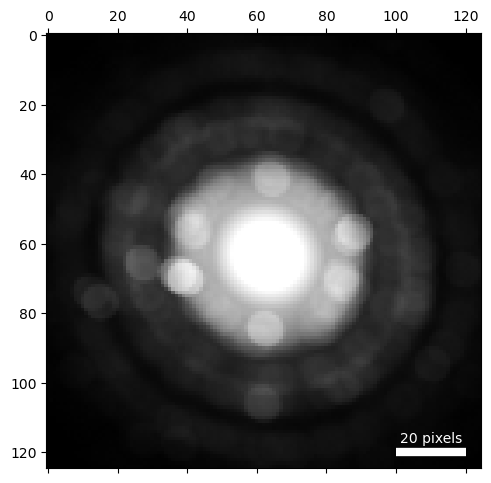

In [50]:
# Mean diffraction
show(basics_01.tree('dp_mean'), scaling='log')

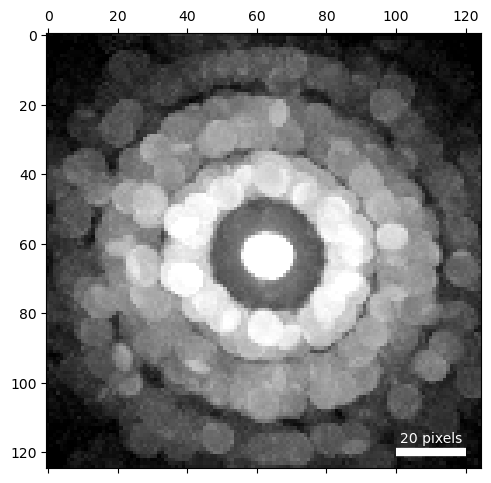

In [51]:
# Max diffraction
show(basics_01.tree('dp_max'), scaling='log')

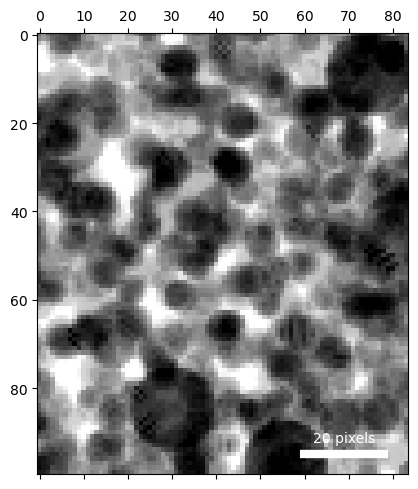

In [52]:
# Virtual BF
show(basics_01.tree('bright_field'))

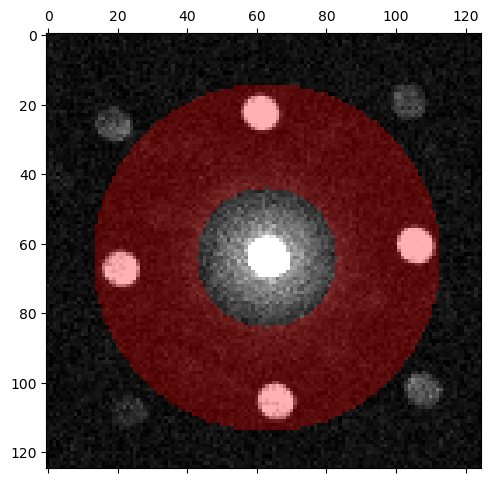

In [157]:
center = 64, 63
r_inner = 20
r_outer = 50
radii = r_inner,r_outer

# overlay selected detector position over mean dp
datacube.position_detector(
    mode = 'annular',
    geometry = (
        center,
        radii
    )
)

100%|██████████| 100/100 [00:00<00:00, 5888.06it/s]


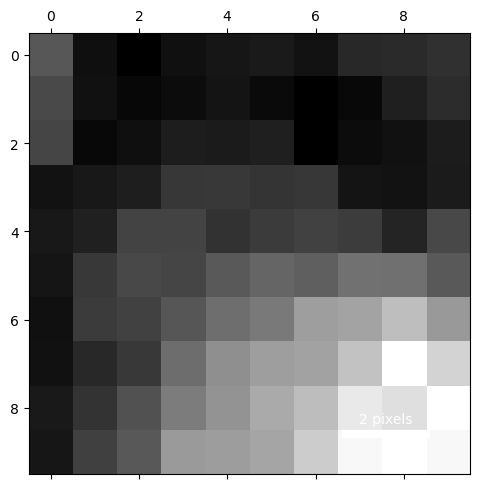

In [158]:
# Capture the virtual ADF

# compute
datacube.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii),
    name = 'annular_dark_field'
)

# show
show(datacube.tree('annular_dark_field'))

In [59]:
# Fourth - find all disks
# Choose disk detection parameters
# set parameters
detect_params = {
    'minAbsoluteIntensity': 8,   # intensity threshold
    'minRelativeIntensity': 0,   # int. thresh. relative to brightest disk in each pattern
    'minPeakSpacing': 4,         # if two peaks are closer than this (in pixels), remove the dimmer peak
    'edgeBoundary': 2,           # remove peaks within this distance of the edge of the diffraction pattern
    'sigma': 0,                  # gaussian blur size to apply to cross correlation before finding maxima
    'maxNumPeaks': 100,          # maximum number of peaks to return, in order of intensity
    'subpixel' : 'poly',         # subpixel resolution method
    'corrPower': 1.0,            # if <1.0, performs a hybrid cross/phase correlation. More sensitive to edges and to noise
#     'CUDA': True,              # if a GPU is configured and cuda dependencies are installed, speeds up calculation 
}

# find disks for selected patterns
disks_selected = datacube.find_Bragg_disks(
    data = (rxs, rys),
    template = probe.kernel,
    **detect_params,
)

# show
py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:datacube[rxs[i],rys[i],:,:],
    H=2, 
    W=3,
    axsize=(5,5),
    intensity_range='absolute',
    vmin=10,
    vmax=500,
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 700,
)

Exception: entry (DataCube( A 4-dimensional array of shape (20, 20, 125, 125) called '4DSTEM_polyAu',
          with dimensions:

              Rx = [0,1,2,...] pixels
              Ry = [0,1,2,...] pixels
              Qx = [0,1,2,...] pixels
              Qy = [0,1,2,...] pixels
), (36, 15, 11, 59, 32, 34), (9, 15, 31, 39, 20, 68)) for `data` could not be parsed

**Disk Detection**

This section performs disk detection using template matching. This works using a cross-correlation, so if you compute the cross-correlation of a template with an image, the maxima of the resulting correlogram correspond to the positions in the image that are good matches to the template.

The steps are:

- Generate a template (the vacuum electron probe)
- Prepare the template for cross correlation (generate a cross correlation kernel from the probe image)
- Select a few scan position and test/refine parameters for the disk detection algorithm
- Find all the disks

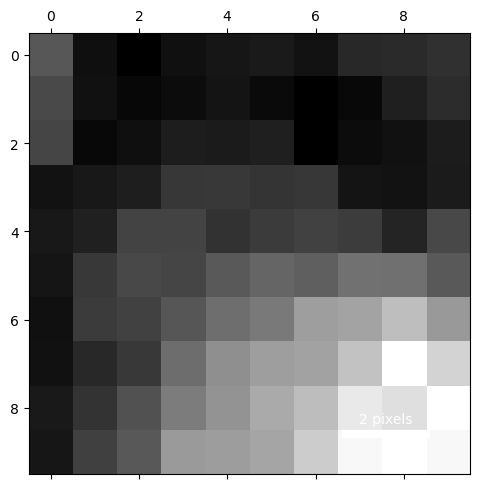

In [161]:
# First, generate a template - vacuum electron probe
# select a vacuum region
mask = np.zeros(datacube.Rshape,dtype=bool)
mask[9:14,15:20] = 1
mask[9:14,15:20] = 1

show(
    datacube.tree('annular_dark_field'), # bright field was changed
    mask = ~mask,
    mask_alpha = 0.667,
    mask_color = 'r'
)

In [162]:
# Second
# Generate a probe
probe = datacube.get_vacuum_probe(ROI=mask)
alpha_pr,qx0_pr,qy0_pr = py4DSTEM.process.calibration.get_probe_size(probe.probe)

IndexError: index 0 is out of bounds for axis 1 with size 0

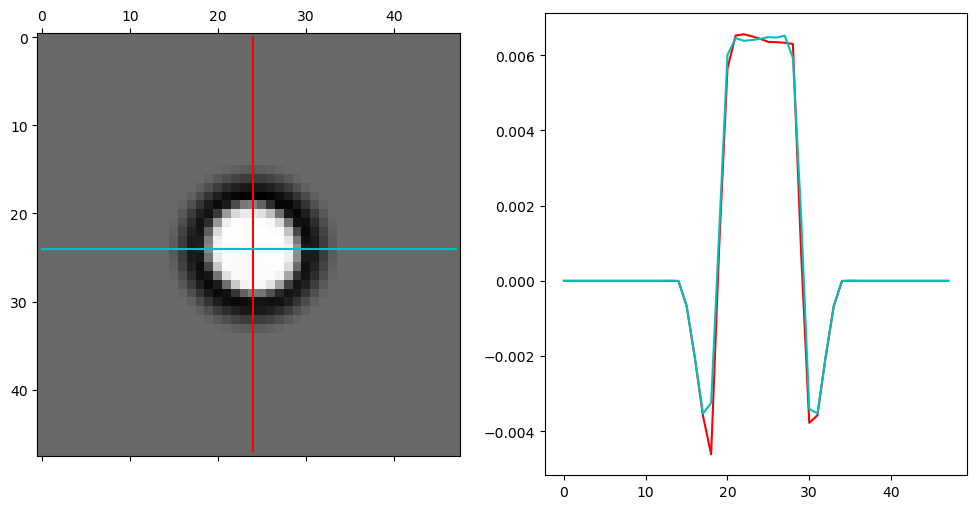

In [163]:
# Prepare the probe kernel
probe.get_kernel(
    mode='sigmoid',
    radii=(alpha_pr,2*alpha_pr)   # the inner and outer radii of the 'trench'
)

py4DSTEM.visualize.show_kernel(
    probe.kernel,
    R = 24,
    L = 24,
    W = 1
)

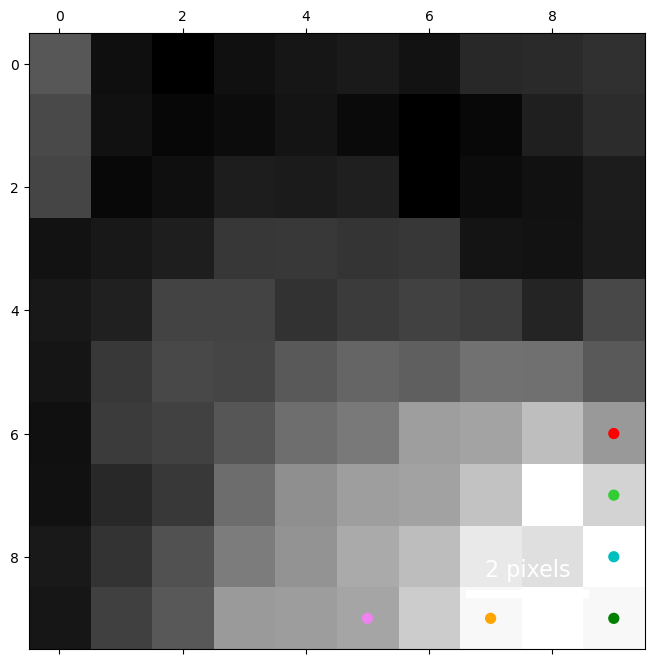

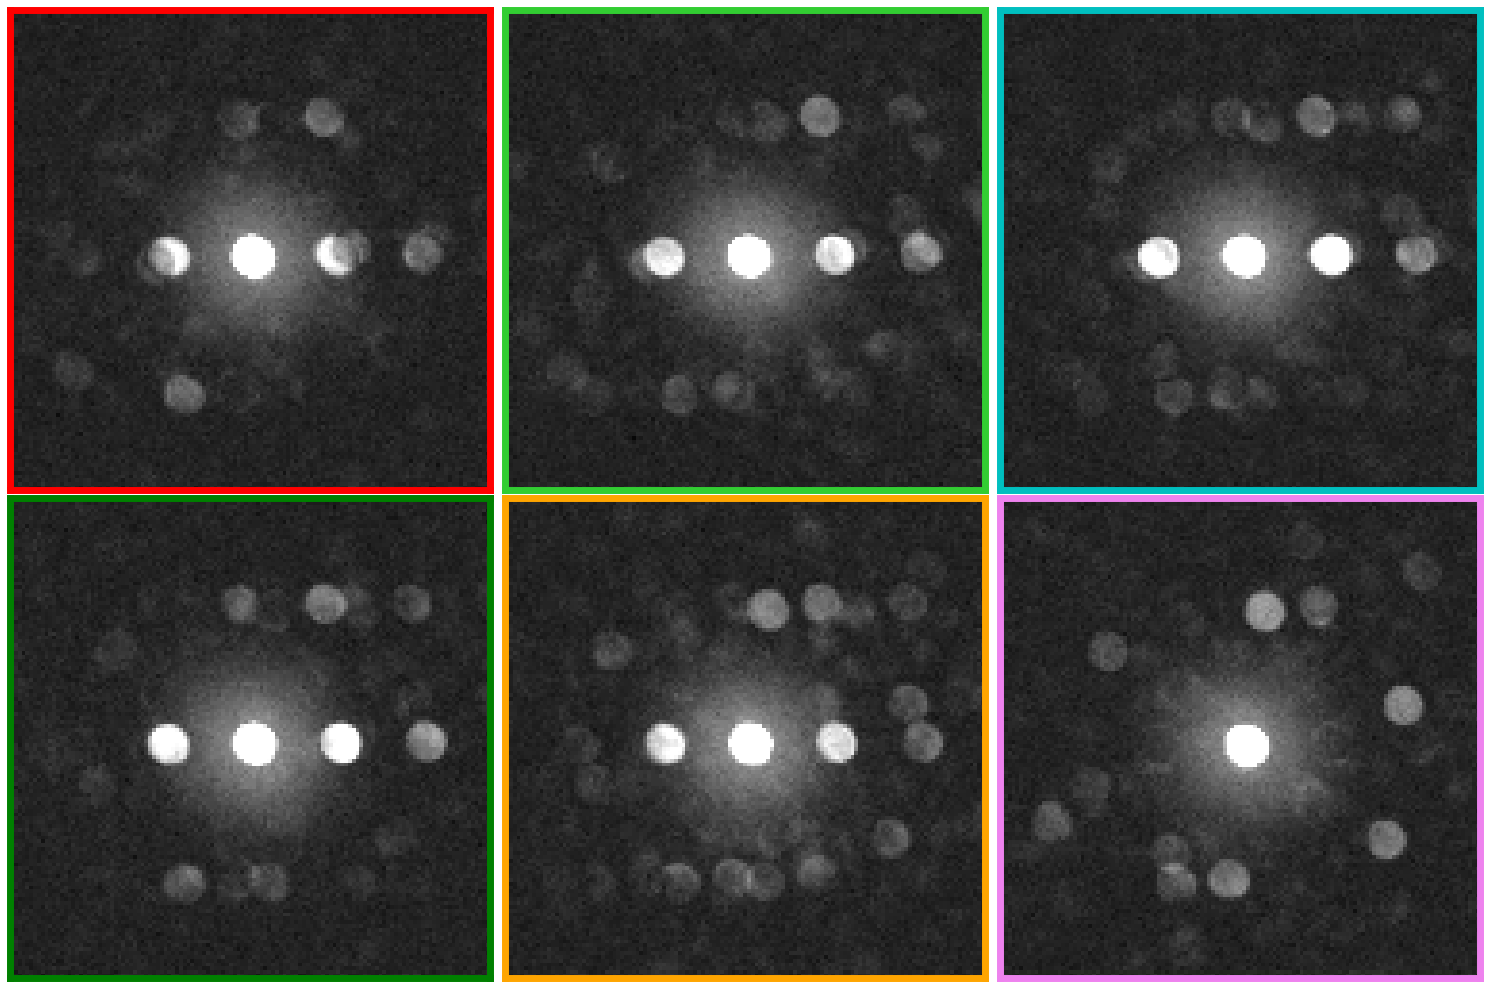

In [197]:
# Third step
# Select a few sample patterns for parameter tuning
# choose scan positions
# rxs = 36,15,11,59,32,34
# rys = 9,15,31,39,20,68,
rxs = 6,7,8,9,9,9
rys = 9,9,9,9,7,5,

# visualize
colors=['r','limegreen','c','g','orange', 'violet']

# show the selected
# positions in real space
py4DSTEM.visualize.show_points(
    datacube.tree('annular_dark_field'),
    x=rxs,
    y=rys,
    pointcolor=colors,
    figsize=(8,8)
)

# show the selected
# diffraction patterns
py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:datacube[rxs[i],rys[i],:,:],
    H=2,W=3,
    axsize=(5,5),
    intensity_range='absolute',
    vmin=10,
    vmax=500,
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
)

# selecting these sections, can see that the bottom right corner must be a different crystal
# the different clusters might correspond to different crystals

**Finding Peak Positions and convert to Points Array**

In [82]:
# compute for all diffraction patterns and find peaks
braggpeaks = datacube.find_Bragg_disks(
    template = probe.kernel,
    **detect_params,
)

Finding Bragg Disks: 100%|██████████| 100/100 [00:00<00:00, 634DP/s] 


In [83]:
# Importing function for converting bragg peaks to an arraylist
def pointlist_to_array(
    bragg_peaks,
    center=None,
    ellipse=None,
    pixel=None,
    rotate=None,
    rphi=True,
):
    """
    This function turns the py4DSTEM BraggVectors to a simple numpy array that is more
    convenient for rapid array processing in numpy

    Parameters
    ----------
    bragg_peaks: BraggVectors
        py4DSTEM BraggVectors
    center: bool
        If True, applies center calibration to bragg_peaks
    ellipse: bool
        if True, applies elliptical calibration to bragg_peaks
    pixel: bool
        if True, applies pixel calibration to bragg_peaks
    rotate: bool
        if True, applies rotational calibration to bragg_peaks
    rphi: bool
        if True, generates two extra columns of Qr and Qphi for addressing in polar
        coordinates, Qphi is the angle in degrees anticlockwise from horizontal to the right

    Returns
    ----------
    points_array: numpy array
         This will be an 2D numpy array of n points x 5 (or 7) columns:
            qx
            qy
            I
            Rx
            Ry
            (qr)
            (qphi)
    """
    if center is None:
        center = bragg_peaks.calstate["center"]

    if ellipse is None:
        ellipse = bragg_peaks.calstate["ellipse"]

    if pixel is None:
        pixel = bragg_peaks.calstate["pixel"]

    if rotate is None:
        rotate = bragg_peaks.calstate["rotate"]

    for i, j in tqdmnd(bragg_peaks.Rshape[0], bragg_peaks.Rshape[1]):
        vectors = bragg_peaks.get_vectors(
            scan_x=i,
            scan_y=j,
            center=center,
            ellipse=ellipse,
            pixel=pixel,
            rotate=rotate,
        )

        if rphi == True:
            if i == j == 0:
                points_array = np.array(
                    [
                        vectors.qx,
                        vectors.qy,
                        vectors.I,
                        vectors.qx.shape[0] * [i],
                        vectors.qx.shape[0] * [j],
                        (vectors.qx**2 + vectors.qy**2) ** 0.5,
                        np.degrees(np.arctan2(-vectors.qx, vectors.qy)),
                    ]
                ).T
            else:
                nps = np.array(
                    [
                        vectors.qx,
                        vectors.qy,
                        vectors.I,
                        vectors.qx.shape[0] * [i],
                        vectors.qx.shape[0] * [j],
                        (vectors.qx**2 + vectors.qy**2) ** 0.5,
                        np.degrees(np.arctan2(-vectors.qx, vectors.qy)),
                    ]
                ).T
                points_array = np.vstack((points_array, nps))

        else:
            if i == j == 0:
                points_array = np.array(
                    [
                        vectors.qx,
                        vectors.qy,
                        vectors.I,
                        vectors.qx.shape[0] * [i],
                        vectors.qx.shape[0] * [j],
                    ]
                ).T
            else:
                nps = np.array(
                    [
                        vectors.qx,
                        vectors.qy,
                        vectors.I,
                        vectors.qx.shape[0] * [i],
                        vectors.qx.shape[0] * [j],
                    ]
                ).T
                points_array = np.vstack((points_array, nps))

    return points_array

In [84]:
# Centre peak positions and convert to pointsarray
PeaksList = pointlist_to_array(braggpeaks,
    center=None,
    ellipse=None,
    pixel=None,
    rotate=None,
    rphi=True,
)

100%|██████████| 100/100 [00:00<00:00, 9980.73it/s]


In [85]:
# Convert from tuple to Array
PeaksArray = np.array(PeaksList)

In [86]:
# Columns represent Qx, Qy, I, Rx, Ry, Qr, Qphi
PeaksArray[:,:]

array([[  63.66644334,   63.35372192, 1783.61795109, ...,    0.        ,
          89.8170924 ,  -45.14106092],
       [  60.39303022,  105.68481698,   61.97390206, ...,    0.        ,
         121.72345147,  -29.74557861],
       [  22.38718078,   61.24181856,   60.68602305, ...,    0.        ,
          65.20541545,  -20.08007831],
       ...,
       [  27.19056633,   59.49433238,   22.83644163, ...,    9.        ,
          65.41332038,  -24.56172029],
       [  27.14435414,  104.44775415,   14.41483121, ...,    9.        ,
         107.91732626,  -14.5680183 ],
       [  99.31367909,   66.89752425,   13.9659304 , ...,    9.        ,
         119.74341571,  -56.03585954]])

In [87]:
# Extract values
Qx = PeaksArray[:, 0]
Qy = PeaksArray[:, 1]
Rx = PeaksArray[:, 3]
Ry = PeaksArray[:, 4]

#Cluster = PeaksArray[:, [0, 1, 3, 4]] # 4 columns 

## Apply clustering for (Qx, Qy) 2D

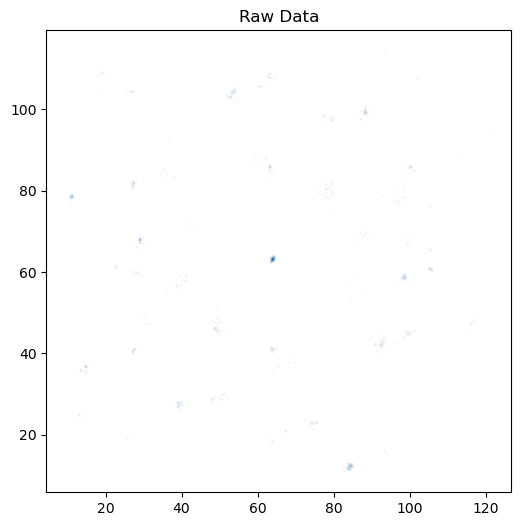

In [101]:
# Plot the data
plt.figure(figsize=[6,6])
plt.title('Raw Data')
plt.scatter(Qx, Qy, s=.11, alpha=.1)
plt.show()

# this is showing an fcc shape - expected for Gold

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.


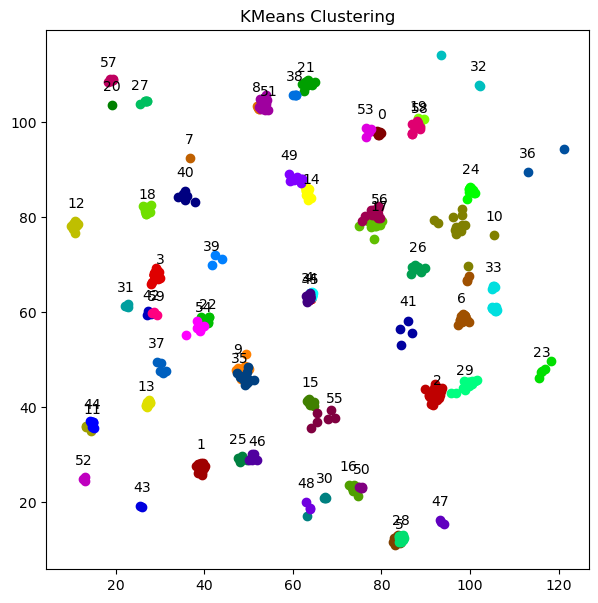

In [191]:
# Colours
colours = []
r = 60
d = 5
for n in range(r):
    # integers
    h, v = int(n/d), n%d 
    # normalisation
    H = h/(r/d)
    V = (4+v)/8
    S = 1
    c = hsv_to_rgb(H,S,V)
    colours += [c] 

# Apply KMeans
k = KMeans(n_clusters=r).fit(PeaksArray[:,[0,1,3,4]])

# Plot
plt.figure(figsize=[7,7])
plt.title('KMeans Clustering')
for i in range(r):
    Cluster = PeaksArray[np.where(k.labels_ == i)]
    scatter = plt.scatter(Cluster[:, 0], Cluster[:, 1], color=colours[i], label = i)
    
    for n in range(0,Cluster.shape[0],4500): # number of iterations 
        plt.text(
            Cluster[n, 0], 
            Cluster[n, 1]+3, 
            int(i),
            horizontalalignment='center'
        )

In [193]:
n = 49
Cluster = PeaksArray[np.where(k.labels_ == n)]
Cluster[0]

array([ 59.08681092,  89.0327867 ,  10.59808372,   2.        ,
         9.        , 106.85545532, -33.57033109])

In [194]:
image = np.zeros(shape=(Rxmax,Rymax))

In [195]:
image[Cluster[:,3].astype('int'),Cluster[:,4].astype('int')] = Cluster[:,2]

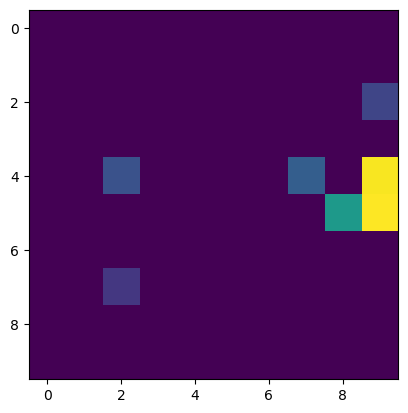

In [196]:
plt.imshow(image)

In [139]:
def VirtualImage(ClusterType, ClusterIndex, Title):
    '''
    Function for plotting the image of a clustered pixel in the real space from reciprocal space.
    Cluster types extract the label from the specified clustering algorithm.

    Data types
    ----------
    ClusterType: String (if db = DBSCAN, then enter db, if k = KMEANS, then k etc.)
    ClusterIndex: Int
    Title: String
    '''
    # Finding max dimensions of Qx, Qy
    Qxmax, Qymax = PeaksArray[:,0].max().astype('int')+1, PeaksArray[:,1].max().astype('int')+1

    # Select a specific cluster points
    Cluster = PeaksArray[np.where(ClusterType.labels_ == ClusterIndex)]

    # Create image 
    image = np.zeros(shape=(Qxmax,Qymax))
    image[Cluster[:,0].astype('int'),Cluster[:,1].astype('int')]

    # Plot
    plt.figure(figsize=[8,8])
    plt.title(Title)
    plt.imshow(image)
    #plt.xlabel('Rx')
    #plt.ylabel('Ry')
    plt.show()

# note - may need to add more inputs to the function to make it more general

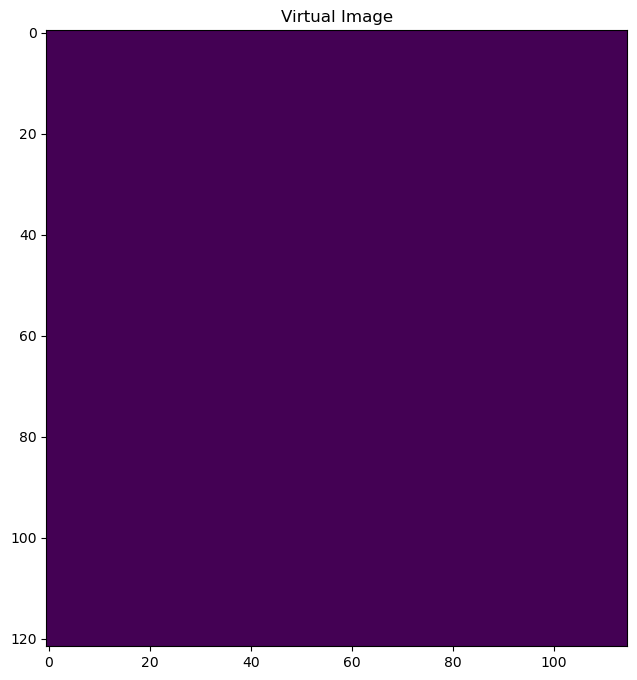

In [140]:
VirtualImage(k, 1, 'Virtual Image')

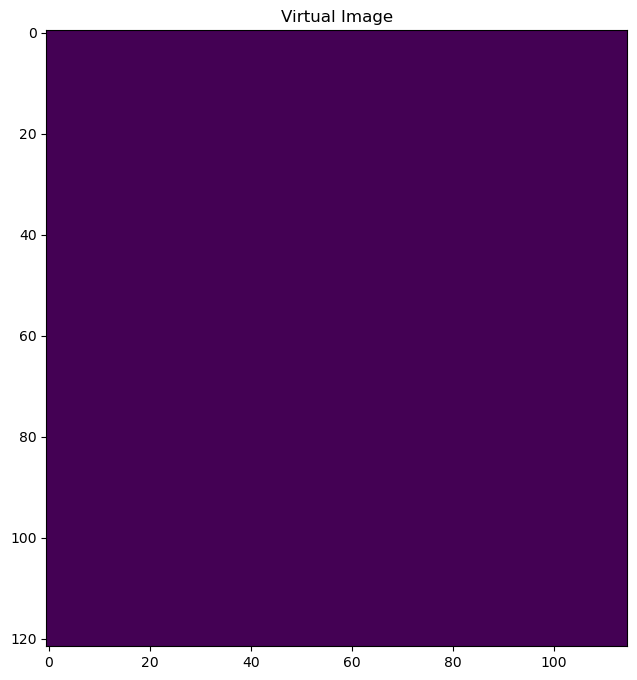

In [141]:
VirtualImage(k, 5, 'Virtual Image')

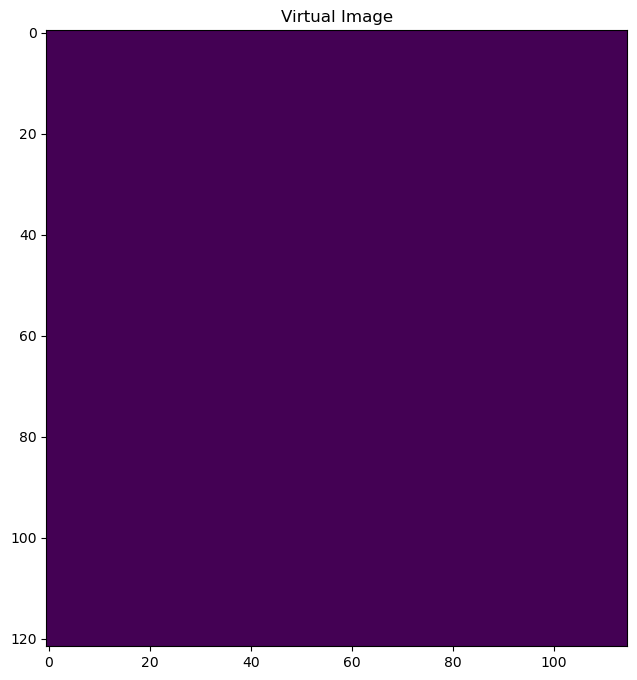

In [142]:
VirtualImage(k, 47, 'Virtual Image')

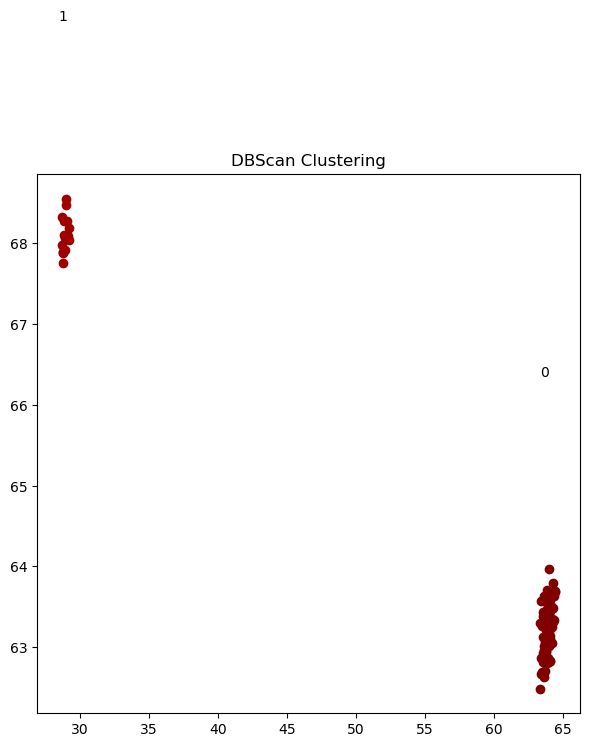

In [109]:
# Colours
r = 10
d = 5
colours = []
for n in range(r):
    h, v = int(n/d), n%d
    H = h/(r/d)
    V = (4+v)/8
    S = 1
    c = hsv_to_rgb(H,S,V)
    colours += [c] 

# Apply DBScan
db = DBSCAN(eps=0.3, min_samples=10).fit(PeaksArray[:,:2])

# Plot
plt.figure(figsize=[7,7])
plt.title('DBScan Clustering')

for i in range(r):   
    Cluster = PeaksArray[np.where(db.labels_ == i)]
    scatter = plt.scatter(Cluster[:, 0], Cluster[:, 1], color=colours[i], label = i)
    
    for n in range(0,Cluster.shape[0],4500): # number of iterations 
        plt.text(
            Cluster[n, 0], 
            Cluster[n, 1]+3, 
            int(i),
            horizontalalignment='center'
        )

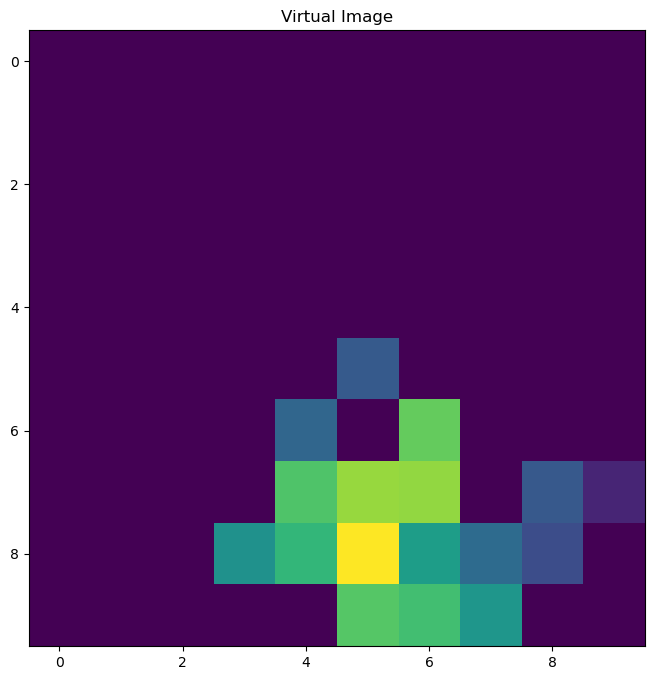

In [112]:
VirtualImage(db, 1, 'Virtual Image')

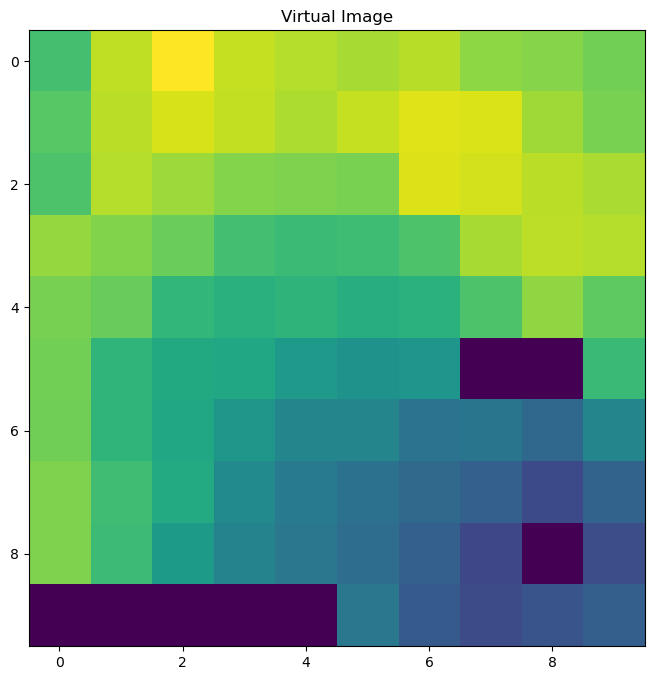

In [113]:
VirtualImage(db, 0, 'Virtual Image')

## Clustering for (Qx, Qy, Rx, Ry) 4D

In [69]:
#PeaksArray[:, [0, 1, 3, 4]] # 4 columns

# Cluster in both Qx,Qy and Rx,Ry 
# Issues with scaling - different spaces have different units

In [78]:
PeaksArray[:, [0, 1, 3, 4]]*np.array([1,1,3,3]) # for scaling


array([[ 63.80605849,  63.25387236,   0.        ,   0.        ],
       [100.74544609,  84.50975064,   0.        ,   0.        ],
       [ 32.18614309, 109.07022302,   0.        ,   0.        ],
       ...,
       [ 27.19056633,  59.49433238,  57.        ,  57.        ],
       [ 27.14435414, 104.44775415,  57.        ,  57.        ],
       [ 99.31367909,  66.89752425,  57.        ,  57.        ]])

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.


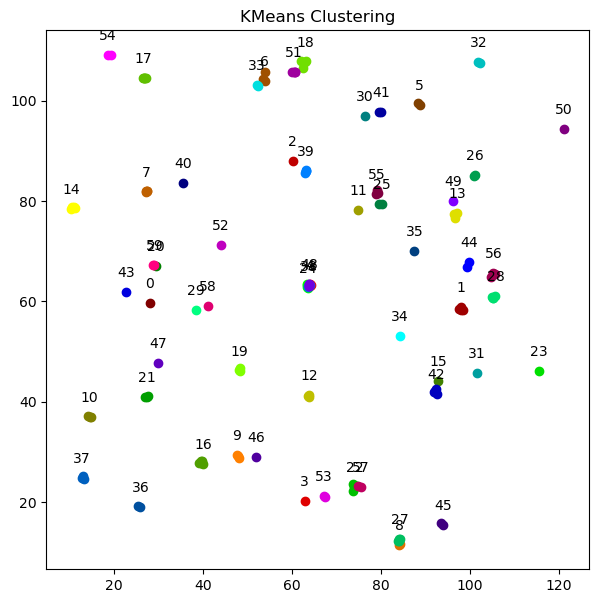

In [92]:
# Apply KMeans
k = KMeans(n_clusters=r).fit(PeaksArray[:, [0, 1, 3, 4]])
#k = KMeans(n_clusters=r).fit(data[:,:2])
r = 60
d = 5
colours = []
for n in range(r):
    h, v = int(n/d), n%d
    H = h/(r/d)
    V = (4+v)/8
    S = 1
    c = hsv_to_rgb(H,S,V)
    colours += [c] 
# Plot
plt.figure(figsize=[7,7])
plt.title('KMeans Clustering')
for i in range(r):
    Cluster = PeaksArray[np.where(k.labels_ == i)]
    scatter = plt.scatter(Cluster[:, 0], Cluster[:, 1], color=colours[i], label = i)
    
    for n in range(0,Cluster.shape[0],4500): # number of iterations 
        plt.text(
            Cluster[n, 0], 
            Cluster[n, 1]+3, 
            int(i),
            horizontalalignment='center'
        )

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.


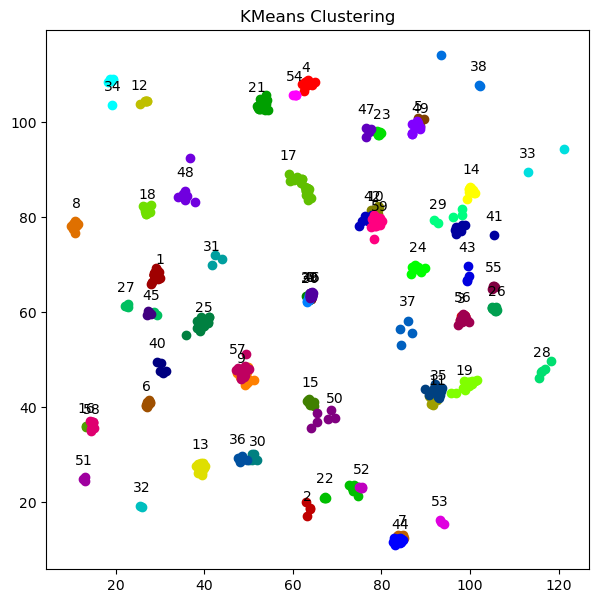

In [93]:
# Apply KMeans
#k = KMeans(n_clusters=r).fit(data[:,:2])
r = 60
d = 5
colours = []
for n in range(r):
    h, v = int(n/d), n%d
    H = h/(r/d)
    V = (4+v)/8
    S = 1
    c = hsv_to_rgb(H,S,V)
    colours += [c] 

# Extract values
s = 0.5 # scale
k = KMeans(n_clusters=r).fit(PeaksArray[:, [0, 1, 3, 4]]) # need to apply scale
    
# Plot
plt.figure(figsize=[7,7])
plt.title('KMeans Clustering')
for i in range(r):
    Cluster = PeaksArray[np.where(k.labels_ == i)]
    scatter = plt.scatter(Cluster[:, 0], Cluster[:, 1], color=colours[i], label = i)
    
    for n in range(0,Cluster.shape[0],4500): # number of iterations 
        plt.text(
            Cluster[n, 0], 
            Cluster[n, 1]+3, 
            int(i),
            horizontalalignment='center'
        )

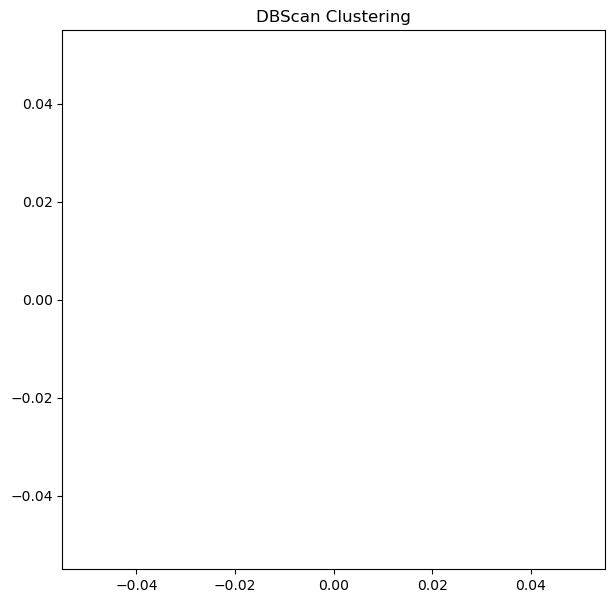

In [94]:
r = 50
d = 5
colours = []
for n in range(r):
    h, v = int(n/d), n%d
    H = h/(r/d)
    V = (4+v)/8
    S = 1
    c = hsv_to_rgb(H,S,V)
    colours += [c] 

# Apply DBScan
db = DBSCAN(eps=0.3, min_samples=10).fit(PeaksArray[:, [0, 1, 3, 4]])

# Plot
plt.figure(figsize=[7,7])
plt.title('DBScan Clustering')

for i in range(r):   
    Cluster = PeaksArray[np.where(db.labels_ == i)]
    scatter = plt.scatter(Cluster[:, 0], Cluster[:, 1], color=colours[i], label = i)
    
    for n in range(0,Cluster.shape[0],4500): # number of iterations 
        plt.text(
            Cluster[n, 0], 
            Cluster[n, 1]+3, 
            int(i),
            horizontalalignment='center'
        )